In [3]:
print("Welcome to Machine Learning!")

Welcome to Machine Learning!


This project requires Python 3.7 or above:

In [4]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [5]:
from packaging import version
import sklearn
from zlib import crc32
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# eTe ML Problem & its steps

Task is to predict median house values in Californian districts, given a number of features from these districts.

## Downloading Data

In [6]:
from pathlib import Path
import pandas as pd
import pandas_profiling
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing_samples = load_housing_data()

# Descriptive Statistics of the Data

Descriptive Statistics is used to get a general understanding of the kind of data we are manipulating.

In [7]:
housing_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We can fetch the value counts from the DataFrame.

In [8]:
housing_samples['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The first 5 samples in the DataFrame

In [9]:
housing_samples.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The last 5 samples in the DataFrame

In [10]:
housing_samples.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


`describe()` give us a good overview of the data.

In [11]:
housing_samples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Selecting a Performance Measure

As we are working regression the two popular solutions.

RMSE (Root Mean Square Error) as default.

$$
\sqrt{\frac{1}{m} \sum_{i=1}^m\left(h\left(x^{(i)}\right)-y^{(i)}\right)^2}
$$

or if there are many outlier districts. In that case, you may consider using MAE (Mean Absolute Erro).

$$
\frac{1}{m} \sum_{i=1}^m\left|h\left(x^{(i)}\right)-y^{(i)}\right|
$$

## Plotting the Data

Creating a histogram for each feature

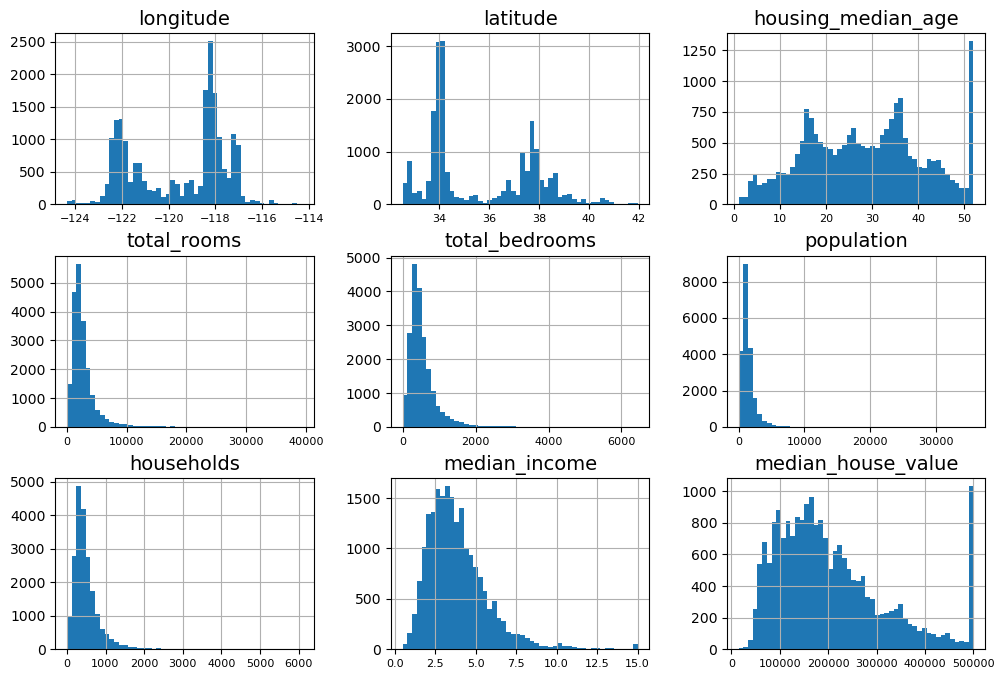

In [12]:
# the histogram have trouble with plotting median_house_value's due to size as it is in houndreds of thousands
# dividing the price with a 1_000 to get shorter number
##housing_samples = housing_samples.rename(columns={'median_house_value':'median_house_value_in_thousands'})

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=10)

housing_samples.hist(bins=50, figsize=(12, 8))
plt.show()


Many of histograms are skewed right: they extend much farther to the
right of the median than to the left. 

This may make it a bit harder for some machine learning algorithms to detect patterns. Later, I’ll try transforming
these features to have more symmetrical and bell-shaped distributions.

## Creating a Test Set

### Example: Implementing Test devider manually (We usually use train_test_split from sklearn)

`zlib` is a built-in module in Python that provides functions for compression and decompression of data.

`crc32` is a function in the zlib module of Python that calculates the cyclic redundancy check (CRC) checksum of a data stream. The CRC checksum is a type of hash code that is used to detect errors in data transmission or storage.

The `crc32` function takes a bytes-like object as input and returns a 32-bit integer that represents the CRC checksum of the data. 

In [13]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

To make the dataframe compatible with the tests, we need to add an identifier to the datataframe.

In [14]:
housing_samples_with_id = housing_samples.reset_index() # adds an `index` column

## sklearn

To ensure that this notebook's outputs remain the same every time we run it, we need to set the random seed:

In [15]:
np.random.seed(42)

In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_samples, test_size=0.2, random_state=42) #20% of the set is set as a test_set

In [17]:
test_set["total_bedrooms"].isnull().sum()

44

Checking the data sets

In [18]:
train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16349.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.565121,35.631252,28.592720,2635.515928,538.923420,1428.123123,500.259993,3.863585,206111.152980
std,1.999323,2.133670,12.618367,2142.925654,418.202807,1134.043862,379.273307,1.907402,114790.075691
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.780000,33.940000,18.000000,1454.750000,296.000000,788.000000,280.000000,2.561150,119400.000000
50%,-118.490000,34.250000,29.000000,2129.000000,437.000000,1169.000000,411.000000,3.524600,179200.000000
75%,-118.010000,37.720000,37.000000,3152.250000,648.000000,1726.000000,606.000000,4.727000,263800.000000
max,-114.310000,41.950000,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [19]:
test_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,4128.00000,4128.000000,4128.000000,4128.000000,4084.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,-119.58804,35.634297,28.826550,2636.751696,533.655730,1414.891231,496.658430,3.899013,209834.472626
std,2.02042,2.145315,12.453216,2330.231265,433.917371,1126.187554,394.352592,1.869154,117753.682098
min,-124.30000,32.560000,2.000000,11.000000,3.000000,8.000000,2.000000,0.499900,14999.000000
25%,-121.83000,33.920000,19.000000,1429.000000,295.000000,781.000000,277.000000,2.578625,121075.000000
50%,-118.51000,34.260000,29.000000,2113.500000,425.000000,1152.000000,403.000000,3.580050,181500.000000
75%,-118.00000,37.710000,37.000000,3123.500000,640.250000,1716.250000,600.000000,4.821875,269900.000000
max,-114.47000,41.820000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,500001.000000


So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of features), but if it is not, you run the risk of introducing a significant sampling bias. 
When employees at a survey company decides to call 1,000 people to ask them a few questions, they don't just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population, with regard to the questions they want to ask. For example, the US population is $51.1 \%$ females and $48.9 \%$ males, so a well-conducted survey in the US would try to maintain this ratio in the sample: 511 females and 489 males (at least if it seems possible that the answers may vary across genders).

To find the probability that a random sample of 1,000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the binomial distribution. The cdf() method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [20]:
# extra code – shows how to compute the 10.7% probability of getting a bad sample

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(f'{(proba_too_small + proba_too_large)*100}%')

10.736798530930056%


This is called stratified sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. If the people running the survey used purely random sampling, there would be about a $10.7 \%$ chance of sampling a skewed test set with less than $48.5 \%$ female or more than $53.5 \%$ female participants. Either way, the survey results would likely be quite biased.


## Income category feature

Suppose you've chatted with some experts who told you that the median income is a very important feature to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset.

Since the median income is a continuous numerical feature, you first need to create an income category feature. Let’s look at the median income histogram more closely:

    Most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code uses the pd.cut() function to create an income category feature with five categories (labeled from 1 to 5); category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on.

In [21]:
housing_samples["income_category"] = pd.cut(housing_samples["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

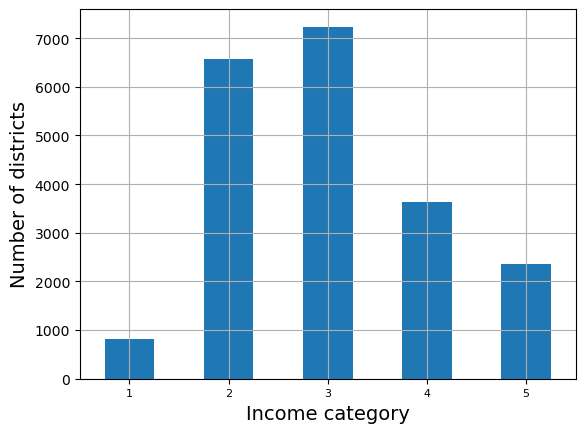

In [22]:
housing_samples["income_category"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

## Stratified Sampling of Income

Scikit-Learn provides a number of splitter classes in the sklearn.model_selection package
that implement various strategies to split your dataset into a training set and a test set.
Each splitter has a split() method that returns an iterator over different training/
test splits of the same data.

To be precise, the split() method yields the training and test indices, not the
data itself. Having multiple splits can be useful if you want to better estimate the
performance of your model, e.g. when using cross-validation.

The following code generates 10 different stratified splits of
the same dataset:

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing_samples, housing_samples["income_category"]):
    strat_train_set_n = housing_samples.iloc[train_index]
    strat_test_set_n = housing_samples.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

For now we will just use the first split

In [24]:
strat_train_set, strat_test_set = strat_splits[0]

Getting the proportions

In [25]:
strat_train_set['income_category'].value_counts() / len(strat_train_set) # the procentage for each category (added together = 1)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_category, dtype: float64

In [26]:
def income_cat_proportions(data):
    return data["income_category"].value_counts() / len(data)

train_set, test_set = train_test_split(housing_samples, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing_samples),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()

compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


I won’t use the income_cat column again, so you might as well drop it, reverting the data back to its original state:

In [27]:
for set_ in (strat_train_set, strat_test_set):set_.drop("income_category", axis=1, inplace=True)

/var/folders/l5/q4487tr5709g4879jv7kvkq40000gn/T/ipykernel_23363/1954571597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for set_ in (strat_train_set, strat_test_set):set_.drop("income_category", axis=1, inplace=True)
/var/folders/l5/q4487tr5709g4879jv7kvkq40000gn/T/ipykernel_23363/1954571597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for set_ in (strat_train_set, strat_test_set):set_.drop("income_category", axis=1, inplace=True)


# Explore and Visualize the Data to Gain Insights
The goal is to get an deeper understanding of the data.

Making sure it is the training set defined from the Descript Statictics I Use

In [28]:
housing_sample = strat_train_set.copy()

Greating a scatterplot: In Steps 1, 2, 3

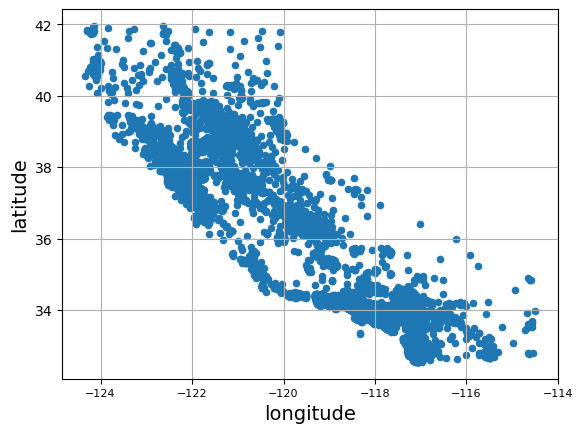

In [29]:
housing_sample.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

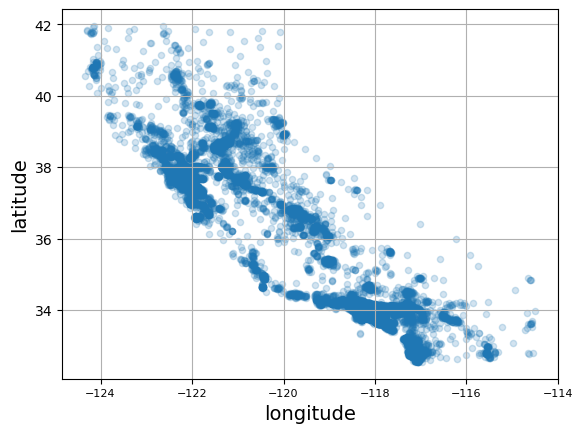

In [30]:
housing_sample.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

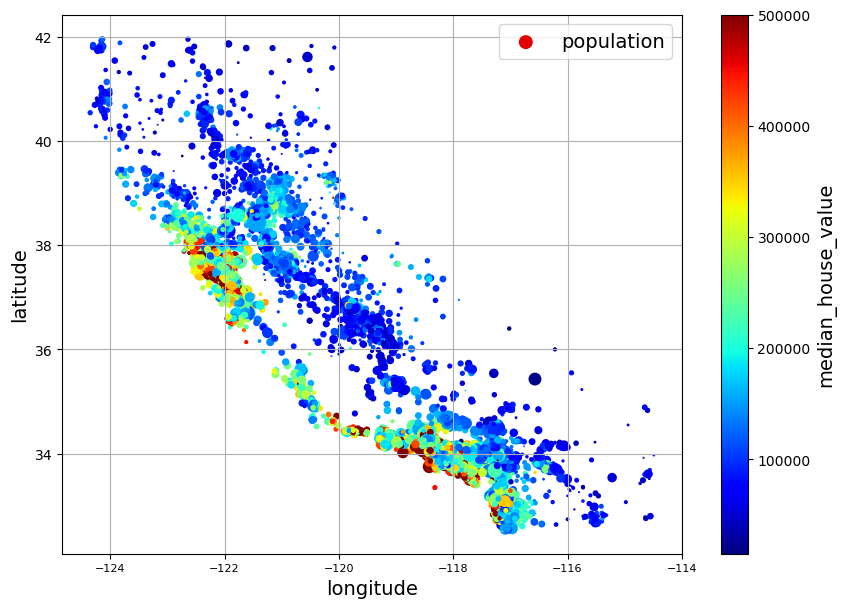

In [31]:
housing_sample.plot(kind="scatter", x="longitude", y="latitude", grid=True,
s=housing_sample["population"] / 100, label="population",
c="median_house_value", cmap="jet", colorbar=True,
legend=True, sharex=False, figsize=(10, 7))
plt.show()

Figure 2-13. California housing prices: red is expensive, blue is cheap, larger circles
indicate areas with a larger population

## Looking for Correlations

Getting the specific correlation values for the median_house_values

In [32]:
corr_matrix = housing_sample.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/var/folders/l5/q4487tr5709g4879jv7kvkq40000gn/T/ipykernel_23363/3911902350.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing_sample.corr()


median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

<AxesSubplot: >

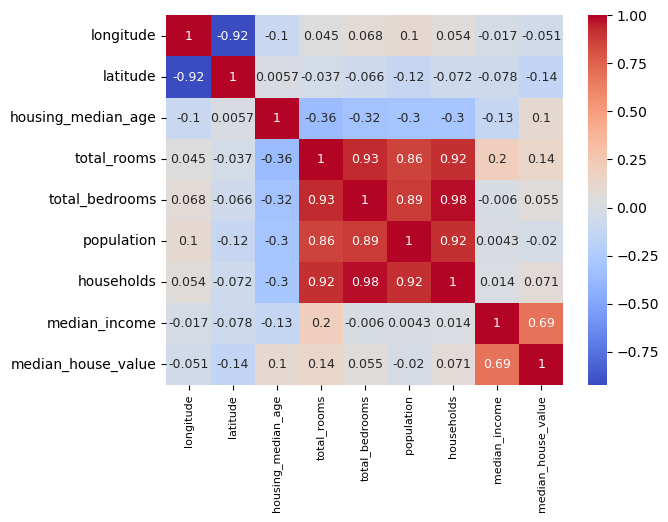

In [33]:
import seaborn as sns

features = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 9})

# Exploring feature Combinations (The Exploration step is iterative!)
You identified a few data quirks that you may want to clean up before feeding the data to a machine learning algorithm, and you found interesting correlations between features, in particular with the target feature.

You may also noticed that some features have a skewed-right distribution, so you may want to transform them. (we can see this on the tail of the histograms)

    (e.g., by computing their logarithm or square root). !This is a techniques we use not matter if its left or right skewed! 

Of course, your mileage will vary considerably with each project, but the general ideas are similar.

One last thing you may want to do before preparing the data for machine learning algorithms is to try out various attribute combinations. 

For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. 

What you really want is the number of rooms per household. 

Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. 

And the population per household also seems like an interesting attribute combination to look at. You create these new attributes as follows:

In [34]:
housing_sample["rooms_per_house"] = housing_sample["total_rooms"] / housing_sample["households"]
housing_sample["bedrooms_ratio"] = housing_sample["total_bedrooms"] / housing_sample["total_rooms"]
housing_sample["people_per_house"] = housing_sample["population"] / housing_sample["households"]

Getting the specific correlation values for the median_house_values

In [35]:
corr_matrix = housing_sample.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

/var/folders/l5/q4487tr5709g4879jv7kvkq40000gn/T/ipykernel_23363/2815530481.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing_sample.corr()


median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

High negative correlation is also a high correlation with the selected feature, the futher away from zero a correlation has the bigger an correlation with the feature 

    (High postive/negative (1, -1))

So here the highest correlation is bedrooms_ratio and median_income.

[ChatGPT Generated]

From the matrix, we can see that "median_income" has the strongest positive correlation with "median_house_value", with a coefficient of 0.688380. This suggests that as the median income of an area increases, the median house value in that area also tends to increase.

We can also see that "bedrooms_ratio" has a negative correlation with "median_house_value", with a coefficient of -0.256397. This suggests that as the ratio of bedrooms to total rooms in a house decreases, the median house value in that area tends to decrease.

## How to work with exploration?

The first round of exploration does not have to be absolutely thorough; the point is tostart off on the right foot and quickly gain insights that will help you get a first
reasonably good prototype. 

But this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

# Preparing Data for Machine Learning Algorithms
Instead of doing data preparation manually, you should write functions for this purpose, for several good reasons:

- This will allow you to reproduce these transformations easily on any dataset (e.g.,the next time you get a fresh dataset).
- You will gradually build a library of transformation functions that you can reuse in future projects.
- You can use these functions in your live system to transform the new data before feeding it to your algorithms.
- This will make it possible for you to easily try various transformations and see which combination of transformations works best.

## Cleaning Data Set

I start with selecting a clean strat_train_set

In [36]:
housing_sample = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

Most machine learning algorithms cannot work with missing features, so you’ll need to take care of these.

You have three options to fix this:

1. Get rid of the corresponding districts.
2. Get rid of the whole feature.
3. Set the missing values to some value (zero, the mean, the median, etc.). This is
called imputation.

You can accomplish these easily using the Pandas DataFrame’s dropna(), drop(), and
fillna() methods:

In [37]:
#housing_sample.dropna(subset=["total_bedrooms"], inplace=True) # option 1

#housing_sample.drop("total_bedrooms", axis=1) # option 2

#median = housing_sample["total_bedrooms"].median() # option 3
#housing_sample["total_bedrooms"].fillna(median, inplace=True)

But the scikit-learn class: `SimpleImputer` is so much easier.

The benefit is that it will store the median value of each feature: this will make it possible to
impute missing values not only on the training set, but also on the validation set, the test set, and any new data fed to the model. 

To use it, first you need to create a SimpleImputer instance, specifying that you want to replace each attribute’s missing
values with the median of that attribute:

In [38]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, you then need to
create a copy of the data with only the numerical attributes (this will exclude the text
attribute ocean_proximity):

In [39]:
housing_num = housing_sample.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [40]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [41]:
imputer.strategy

'median'


Check that this is the same as manually computing the median of each feature:

In [42]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [43]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

Transform the training set:

Now you can use this “trained” imputer to transform the training set by replacing
missing values with the learned medians.

In [44]:
X = imputer.transform(housing_num)

Missing values can also be replaced with the mean value (strategy="mean"), or
with the most frequent value (strategy="most_frequent"), or with a constant
value (strategy="constant", fill_value=…). The last two strategies support nonnumerical
data.

    There are also more powerful imputers available in the
    sklearn.impute package (both for numerical features only):
    
        - KNNImputer replaces each missing value with the mean of the
        k-nearest neighbors’ values for that feature. The distance is
        based on all the available features.
        
        - IterativeImputer trains a regression model per feature to
        predict the missing values based on all the other available
        features. It then trains the model again on the updated data,
        and repeats the process several times, improving the models
        and the replacement values at each iteration.

### Outliers

Some outliers represent natural variations in the population, and they should be left as is in your dataset. These are called true outliers. Other outliers are problematic and should be removed because they represent measurement errors, data entry or processing errors, or poor sampling.

In [45]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)
print(outlier_pred)

[-1  1  1 ...  1  1  1]


If we wanted to remove this outliers we would run this code:

In [46]:
#housing_sample= housing_sample.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]

### Working with the transformed data set

Scikit-Learn transformers output NumPy arrays (or sometimes SciPy sparse matrices) even when they are fed Pandas DataFrames as input.

So, the output of imputer.transform(housing_num) is a NumPy array: X has neither column names nor index. 

Luckily, it’s not too hard to wrap X in a DataFrame and recover the column names and index from housing_num:

In [47]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

Checking if there is any null values left

In [48]:
nullcheck = housing_tr.isnull().sum()

print(nullcheck)

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64


## Handling Text & Categorical Features
So far we have only dealt with numerical features, but data sets may also contain features with text. 

IN the housing data set, the ocean_promixity is the t
he only Text based feature. 

Let take a look at it:

In [49]:
housing_category = housing_sample[['ocean_proximity']]
housing_category.head()

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN


It’s not arbitrary text (there are a limited number of possible values), each of which represents a category. So this attribute is a categorical feature.

Most machine learning algorithms prefer to work with numbers, so let’s convert these categories
from text to numbers. For this, we can use Scikit-Learn’s OrdinalEncoder class:

In [50]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder() #Ordinal
housing_category_encoded = ordinal_encoder.fit_transform(housing_category)
print(housing_category_encoded[:8])

[[3.]
 [0.]
 [1.]
 [1.]
 [4.]
 [1.]
 [0.]
 [3.]]


In [51]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### USE OneHotEncoder!!!

One issue with this representation is that ML algorithms will assume that two nearby
values are more similar than two distant values. This may be fine in some cases
(e.g., for ordered categories such as “bad”, “average”, “good”, and “excellent”), but it is
obviously not the case for the ocean_proximity column (for example, categories 0
and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common
solution is to create one binary attribute per category: one attribute equal to 1 when
the category is "<1H OCEAN" (and 0 otherwise), another attribute equal to 1 when the
category is "INLAND" (and 0 otherwise), and so on. This is called one-hot encoding,
because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).
The new attributes are sometimes called dummy attributes. Scikit-Learn provides a
OneHotEncoder class to convert categorical values into one-hot vectors:

By default, the output of a OneHotEncoder is a SciPy sparse matrix, instead of a
NumPy array:

    OneHotEncoder remembers which categories it was trained
    on. This is very important because once your model is in production, it should be
    fed exactly the same features as during training: no more, no less.
    It will detect the unknown category and raise an exception. 

    

Alternatively, you can set sparse=False when creating the OneHotEncoder, in which
case the transform() method will return a regular (dense) NumPy array directly.

In [52]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False) #Hot
housing_cat_1hot = cat_encoder.fit_transform(housing_category)
housing_cat_1hot # Printing the type of the data

/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

We can see here that is has 5 columns and 16512 samples

you can get the list of categories using the encoder’s
categories_ instance variable:

In [53]:
print(housing_cat_1hot) # We take a look at some of the samples


[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [54]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Pandas has a function called get_dummies(), which also converts each categorical
feature into a one-hot representation, with one binary feature per category:

In [55]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


Look what our trained cat_encoder outputs when we make it transform the same df_test (using
transform(), not fit_transform()):

In [56]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

See the difference? get_dummies() saw only two categories, so it output two columns,
whereas OneHotEncoder output one column per learned category, in the right order.
Moreover, if you feed get_dummies() a DataFrame containing an unknown category
(e.g., "<2H OCEAN"), it will happily generate a column for it:

    If a categorical attribute has a large number of possible categories
    (e.g., country code, profession, species), then one-hot encoding
    will result in a large number of input features. This may slow
    down training and degrade performance. If this happens, you may
    want to replace the categorical input with useful numerical features
    related to the categories: for example, you could replace the
    ocean_proximity feature with the distance to the ocean (similarly,
    a country code could be replaced with the country’s population and
    GDP per capita). Alternatively, you can use one of the encoders
    provided by the category_encoders package on GitHub. Or, when
    dealing with neural networks, you can replace each category with
    a learnable, low-dimensional vector called an embedding. This is
    an example of representation learning (see Chapters 13 and 17 for
    more details).

### Building a DataFrame around the transformers output

In [57]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [58]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [59]:
df_output = pd.DataFrame(cat_encoder.transform(df_test), columns=cat_encoder.get_feature_names_out(), index=df_test.index)

## Feature Scaling & Transformation

One of the most important transformations you need to apply to your data is feature
scaling. With few exceptions, machine learning algorithms don’t perform well when
the input numerical attributes have very different scales. 

IN this is the case for the
housing data: the total number of rooms ranges from about 6 to 39,320, while the
median incomes only range from 0 to 15. Without any scaling, most models will be
biased toward ignoring the median income and focusing more on the number of
rooms.

There are two common ways to get all features to have the same scale: min-max
scaling and standardization.

    As with all estimators, it is important to fit the scalers to the training
    data only: never use fit() or fit_transform() for anything
    else than the training set. Once you have a trained scaler, you can
    then use it to transform() any other set, including the validation
    set, the test set, and new data. Note that while the training set
    values will always be scaled to the specified range, if new data
    contains outliers, these may end up scaled outside the range. If you
    want to avoid this, just set the clip hyperparameter to True.

Min-max scaling (many people call this normalization) is the simplest: for each
attribute, the values are shifted and rescaled so that they end up ranging from
0 to 1. This is performed by subtracting the min value and dividing by the difference
between the min and the max. Scikit-Learn provides a transformer called
MinMaxScaler for this. It has a feature_range hyperparameter that lets you change
the range if, for some reason, you don’t want 0–1 (e.g., neural networks work best
with zero-mean inputs, so a range of –1 to 1 is preferable). It’s quite easy to use:

In [60]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

Standardization is different: first it subtracts the mean value (so standardized values
have a zero mean), then it divides the result by the standard deviation (so standardized
values have a standard deviation equal to 1). Unlike min-max scaling, standardization
does not restrict values to a specific range. However, standardization is much
less affected by outliers. For example, suppose a district has a median income equal
to 100 (by mistake), instead of the usual 0–15. Min-max scaling to the 0–1 range
would map this outlier down to 1 and it would crush all the other values down to
0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a
transformer called StandardScaler for standardization:

In [61]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

When a feature’s distribution has a heavy tail (i.e., when values far from the mean
are not exponentially rare), both min-max scaling and standardization will squash
most values into a small range. Machine learning models generally don’t like this
at all, as you will see in Chapter 4. So before you scale the feature, you should first
transform it to shrink the heavy tail, and if possible to make the distribution roughly
symmetrical. For example, a common way to do this for positive features with a heavy
tail to the right is to replace the feature with its square root (or raise the feature to
a power between 0 and 1). If the feature has a really long and heavy tail, such as a
power law distribution, then replacing the feature with its logarithm may help.

As an example we can convert population to log of population to get a better distribution.

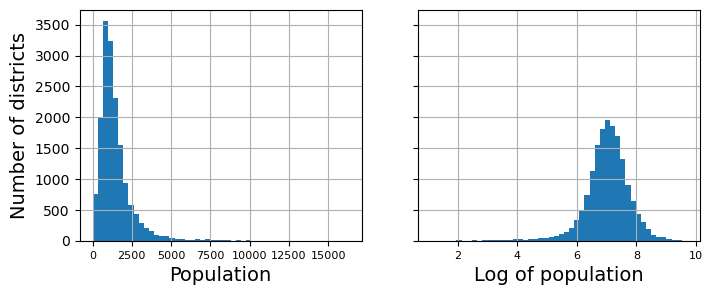

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing_sample["population"].hist(ax=axs[0], bins=50)
housing_sample["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

    Another approach to handle heavy-tailed features consists in bucketizing the feature.
    This means chopping its distribution into roughly equal-sized buckets, and replacing
    each feature value with the index of the bucket it belongs to, much like we did to
    create the income_cat feature.





For example, you could replace each value with its percentile. Bucketizing with
equal-sized buckets results in a feature with an almost uniform distribution, so there’s
no need for further scaling, or you can just divide by the number of buckets to force
the values to the 0–1 range.

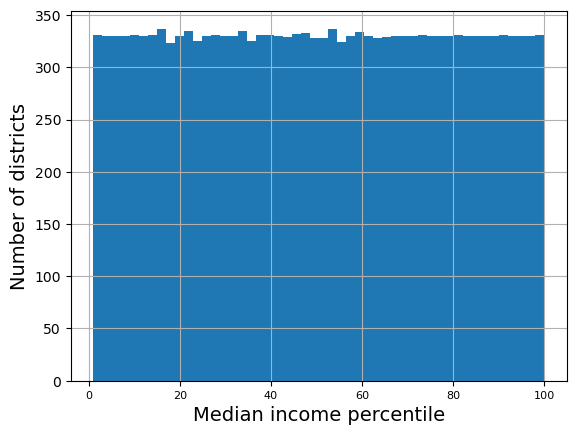

In [63]:
percentiles = [np.percentile(housing_sample["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing_sample["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

    When a feature has a multimodal distribution (i.e., with two or more clear peaks,
    called modes), such as the housing_median_age feature, it can also be helpful to
    bucketize it, but this time treating the bucket IDs as categories, rather than as numerical
    values. This means that the bucket indices must be encoded, for example using a
    OneHotEncoder (so you usually don’t want to use too many buckets). This approach
    will allow the regression model to more easily learn different rules for different ranges
    of this feature value.

Scikit-Learn’s TransformedTargetRegressor will automatically use the transformer to scale the labels and train the regression model on the resulting scaled labels, just like we did previously. Then, when we want to make a prediction, it
will call the regression model’s predict() method and use the scaler’s inverse_trans
form() method to produce the prediction:

In [ ]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())
model = LinearRegression()
model.fit(housing_sample[["median_income"]], scaled_labels)
some_new_data = housing_sample[["median_income"]].iloc[:5] # pretend this is new data
scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

This works fine, but a simpler option is to use a TransformedTargetRegressor. We
just need to construct it, giving it the regression model and the label transformer,
then fit it on the training set, using the original unscaled labels. It will automatically
use the transformer to scale the labels and train the regression model on the resulting
scaled labels, just like we did previously. Then, when we want to make a prediction, it
will call the regression model’s predict() method and use the scaler’s inverse_trans
form() method to produce the prediction:

In [64]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression

some_new_data = housing_sample[["median_income"]].iloc[:5]
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing_sample[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

Generating predictions!

In [65]:
print(predictions)

[131997.15275877 299359.35844434 146023.37185694 138840.33653057
 192016.61557639]


## Custom Transformers

    For transformations that don’t require any training, you can just write a function
    that takes a NumPy array as input and outputs the transformed array. For example,
    as discussed in the previous section, it’s often a good idea to transform features
    with heavy-tailed distributions by replacing them with their logarithm (assuming the
    feature is positive and the tail is on the right).

Let’s create a log-transformer and apply
it to the population feature:

The inverse_func argument is optional. It lets you specify an inverse transform
function, e.g., if you plan to use your transformer in a TransformedTargetRegressor.

In [82]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing_sample[["population"]])

Your transformation function can take hyperparameters as additional arguments. For
example, here’s how to create a transformer that computes the same Gaussian RBF
similarity measure as earlier:

In [85]:
from sklearn.metrics.pairwise import rbf_kernel

rbf_transformer = FunctionTransformer(rbf_kernel,
kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing_sample[["housing_median_age"]])

Custom transformers are also useful to combine features. For example, here’s a
FunctionTransformer that computes the ratio between the input features 0 and 1:

In [86]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])

In [87]:
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

    If you would like your custom transformer to
    be trainable, learning some parameters in the fit() method and using them later
    in the transform() method? For this, you need to write a custom class. Scikit-Learn
    relies on duck typing, so this class does not have to inherit from any particular base
    class. All it needs is three methods: fit() (which must return self), transform(),
    and fit_transform().
    You can get fit_transform() for free by simply adding TransformerMixin as a base
    class: the default implementation will just call fit() and then transform(). If you
    add BaseEstimator as a base class (and avoid using *args and **kwargs in your
    constructor), you will also get two extra methods: get_params() and set_params().
    These will be useful for automatic hyperparameter tuning.

For example, here’s a custom transformer that acts much like the StandardScaler:

In [80]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    
    def __init__(self, with_mean=True): # no *args or **kwargs!
        self.with_mean = with_mean
    
    def fit(self, X, y=None): # y is required even though we don't use it
        X = check_array(X) # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # every estimator stores this in fit()
        return self # always return self!
    
    def transform(self, X):
        check_is_fitted(self) # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

Here are a few things to note:
- The sklearn.utils.validation package contains several functions we can use to validate the inputs. For simplicity, we will skip such tests in the rest of this book, but production code should have them.
- Scikit-Learn pipelines require the $f i t()$ method to have two arguments $X$ and $y$, which is why we need the $y=$ None argument even though we don't use $y$.
- All Scikit-Learn estimators set n_features_in_in the fit() method, and they ensure that the data passed to transform() or predict() has this number of features.
- The fit() method must return self.
- This implementation is not $100 \%$ complete: all estimators should set feature_names_in_in the fit() method when they are passed a DataFrame. Moreover, all transformers should provide a get_feature_names_out() method, as well as an inverse_transform() method when their transformation can be reversed. See the last exercise at the end of this chapter for more details.

A custom transformer can (and often does) use other estimators in its implementation. For example, the following code demonstrates custom transformer that uses a KMeans clusterer in the fit() method to identify the main clusters in the training data, and then uses rbf_kernel() in the transform() method to measure how similar each sample is to each cluster center:

In [81]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self!
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

    You can check whether your custom estimator respects Scikit-
    Learn’s API by passing an instance to check_estimator() from
    the sklearn.utils.estimator_checks package. For the full API,
    check out https://scikit-learn.org/stable/developers.

## Transformation Pipelines

As you can see, there are many data transformation steps that need to be executed
in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with
such sequences of transformations. Here is a small pipeline for numerical features,
which will first impute then scale the input features.

The Pipeline constructor takes a list of name/estimator pairs (2-tuples) defining a
sequence of steps. The names can be anything you like, as long as they are unique
and don’t contain double underscores (__). They will be useful later, when we discuss
hyperparameter tuning. The estimators must all be transformers (i.e., they must
have a fit_transform() method), except for the last one, which can be anything: a
transformer, a predictor, or any other type of estimator.

In [68]:
from sklearn.pipeline import Pipeline
import sklearn

sklearn.set_config(display="diagram")
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

If multiple transformers have the same name, an index is appended to their names
(e.g., "foo-1", "foo-2", etc.).

    In a Jupyter notebook, if you import sklearn and run sklearn.
    set_config(display="diagram"), all Scikit-Learn estimators will
    be rendered as interactive diagrams. This is particularly useful for
    visualizing pipelines. To visualize num_pipeline, run a cell with
    num_pipeline as the last line. Clicking an estimator will show more
    details.

    The pipeline exposes the same methods as the final estimator. In this example the
    last estimator is a StandardScaler, which is a transformer, so the pipeline also acts
    like a transformer. If you call the pipeline’s transform() method, it will sequentially
    apply all the transformations to the data. If the last estimator were a predictor instead
    of a transformer, then the pipeline would have a predict() method rather than a
    transform() method. Calling it would sequentially apply all the transformations to
    the data and pass the result to the predictor’s predict() method.

Let’s call the pipeline’s fit_transform() method and look at the output’s first two
rows, rounded to two decimal places:

In [69]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

if you want to recover a nice DataFrame, you can use the pipeline’s
get_feature_names_out() method:

In [70]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, 
                                       columns=num_pipeline.get_feature_names_out(),
                                       index=housing_num.index)

Pipelines support indexing; for example, pipeline[1] returns the second estimator
in the pipeline, and pipeline[:-1] returns a Pipeline object containing all but the
last estimator. You can also access the estimators via the steps attribute, which is a
list of name/estimator pairs, or via the named_steps dictionary attribute, which maps
the names to the estimators. For example, num_pipeline["simpleimputer"] returns
the estimator named "simpleimputer".

    So far, we have handled the categorical columns and the numerical columns separately.
    It would be more convenient to have a single transformer capable of handling
    all columns, applying the appropriate transformations to each column. For this,
    you can use a ColumnTransformer.

For example, the following ColumnTransformer
will apply num_pipeline (the one we just defined) to the numerical attributes and
cat_pipeline to the categorical attribute:

In [71]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline # Enables name free pipeline declaration (pipeline() alternative)

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

    Since listing all the column names is not very convenient, Scikit-Learn provides
    a make_column_selector() function that returns a selector function you can use
    to automatically select all the features of a given type, such as numerical or categorical.
    You can pass this selector function to the ColumnTransformer instead of
    column names or indices. Moreover, if you don’t care about naming the transformers,
    you can use make_column_transformer(), which chooses the names for you,
    just like make_pipeline() does.

In [72]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

Now we’re ready to apply this ColumnTransformer to the housing data:

In [73]:
housing_prepared = preprocessing.fit_transform(housing_sample)

Great! We have a preprocessing pipeline that takes the entire training dataset and
applies each transformer to the appropriate columns, then concatenates the transformed
columns horizontally (transformers must never change the number of rows).
Once again this returns a NumPy array, but you can get the column names using
preprocessing.get_feature_names_out() and wrap the data in a nice DataFrame
as we did before.

    The OneHotEncoder returns a sparse matrix and the num_pipeline
    returns a dense matrix. When there is such a mix of sparse and
    dense matrices, the ColumnTransformer estimates the density of the
    final matrix (i.e., the ratio of nonzero cells), and it returns a sparse
    matrix if the density is lower than a given threshold (by default,
    sparse_threshold=0.3). In this example, it returns a dense matrix.

Almost ready to train some models!

Let’s recap what the pipeline will do and why:

- Missing values in numerical features will be imputed by replacing them with the median, as most ML algorithms don't expect missing values. In categorical features, missing values will be replaced by the most frequent category.

- The categorical feature will be one-hot encoded, as most ML algorithms only accept numerical inputs.

- A few ratio features will be computed and added: bedrooms_ratio, rooms_per_house, and people_per_house. Hopefully these will better correlate with the median house value, and thereby help the ML models.

- A few cluster similarity features will also be added. These will likely be more useful to the model than latitude and longitude.

- Features with a long tail will be replaced by their logarithm, as most models prefer features with roughly uniform or Gaussian distributions.

- All numerical features will be standardized, as most ML algorithms prefer when all features have roughly the same scale.



The code that builds the pipeline to do all of this should look familiar to you by now:

In [76]:
from sklearn.preprocessing import FunctionTransformer

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out

def ratio_pipeline():
    return make_pipeline(SimpleImputer(
        strategy="median"), 
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(SimpleImputer(
    strategy="median"), 
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
StandardScaler())

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline) # one column remaining: housing_median_age

If you run this ColumnTransformer, it performs all the transformations and outputs a
NumPy array with 24 features:

In [89]:
housing_prepared = preprocessing.fit_transform(housing_sample)
housing_prepared.shape

/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16512, 24)

In [90]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Select and Train a Model
At last! You framed the problem, you got the data and explored it, you sampled a
training set and a test set, and you wrote a preprocessing pipeline to automatically
clean up and prepare your data for machine learning algorithms. You are now ready
to select and train a machine learning model.

## Train and Evaluate on the Training Set

The good news is that thanks to all these previous steps, things are now going to be
easy! You decide to train a very basic linear regression model to get started (layout is printed due to diagram config in sklearn):

In [92]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing_sample, housing_labels)

/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x295...
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2949bae90>)])),
                ('linearregression', LinearRegression())])

You now have a working linear regression model. You try it out on the training
set, looking at the first five predictions and comparing them to the labels:

 a linear regression model (lin_reg) is being used to make predictions on a sample of housing data (housing_sample). 

In [93]:
housing_predictions = lin_reg.predict(housing_sample)

The first five predictions are then rounded to the nearest 100 and displayed.

In [94]:
housing_predictions[:5].round(-2)

array([243700., 372400., 128800.,  94400., 328300.])

We will measure it against the values we have in the sample:

In [95]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [96]:
458300 - 243700

214600

Well, it works, but not always: the first prediction is way off (by over $200,000!)

while the other predictions are better: two are off by about 25%, and two are off
by less than 10%.

Remember that you chose to use the RMSE as your performance
measure, so you want to measure this regression model’s RMSE on the whole training
set using Scikit-Learn’s mean_squared_error() function, with the squared argument
set to False:

In [97]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

68687.8917659003

This is better than nothing, but clearly not a great score: the median_housing_values
of most districts range between $120,000 and $265,000, so a typical prediction error
of $68,628 is really not very satisfying. 

    This is an example of a model underfitting the
    training data. When this happens it can mean that the features do not provide enough
    information to make good predictions, or that the model is not powerful enough.

    The main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, which rules out the last option. You could try to add more features, but first you want to try a more complex
    model to see how it does.

Lets try a DecisionTreeRegressor, as this is a fairly powerful model capable
of finding complex nonlinear relationships in the data (decision trees are presented in
more detail in Chapter 6):

In [99]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing_sample, housing_labels)

/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x295...
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2949bae90>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [101]:
housing_predictions = tree_reg.predict(housing_sample)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course,
it is much more likely that the model has badly overfit the data. How can you be sure?
As you saw earlier, you don’t want to touch the test set until you are ready to launch a
model you are confident about, so you need to use part of the training set for training
and part of it for model validation.

## Better Evaluation Using Cross-Validation

Scikit-Learn’s k_-fold cross-validation feature. The following
code randomly splits the training set into 10 nonoverlapping subsets called folds,
then it trains and evaluates the decision tree model 10 times, picking a different fold
for evaluation every time and using the other 9 folds for training. The result is an
array containing the 10 evaluation scores:

In [103]:
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(tree_reg, housing_sample, housing_labels,
scoring="neg_root_mean_squared_error", cv=10)

/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

In [104]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

Now the decision tree doesn’t look as good as it did earlier. In fact, it seems to
perform almost as poorly as the linear regression model! Notice that cross-validation
allows you to get not only an estimate of the performance of your model, but also a
measure of how precise this estimate is (i.e., its standard deviation). The decision tree
has an RMSE of about 66,868, with a standard deviation of about 2,061. You would
not have this information if you just used one validation set. But cross-validation
comes at the cost of training the model several times, so it is not always feasible.

Let’s try one last model now: the RandomForestRegressor. As you will see in Chapter
7, random forests work by training many decision trees on random subsets of
the features, then averaging out their predictions. Such models composed of many
other models are called ensembles: they are capable of boosting the performance of the underlying model (in this case, decision trees). The code is much the same as
earlier:

In [106]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = make_pipeline(preprocessing,
RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing_sample, housing_labels,
scoring="neg_root_mean_squared_error", cv=10)

/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

In [107]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47019.561281
std       1033.957120
min      45458.112527
25%      46464.031184
50%      46967.596354
75%      47325.694987
max      49243.765795
dtype: float64

Wow, this is much better: random forests really look very promising for this task!
However, if you train a RandomForest and measure the RMSE on the training set,
you will find roughly 17,474: that’s much lower, meaning that there’s still quite a
lot of overfitting going on. 

    Possible solutions are to simplify the model, constrain
    it (i.e., regularize it), or get a lot more training data. 
    
Before you dive much deeper
into random forests, however, you should: 

    try out many other models from various
    categories of machine learning algorithms (e.g., several support vector machines with
    different kernels, and possibly a neural network), without spending too much time
    tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising
    models.

# Fine-Tune Your Model
Let’s assume that you now have a shortlist of promising models. You now need to
fine-tune them. Let’s look at a few ways you can do that.

One option would be to fiddle with the hyperparameters manually, until you find a
great combination of hyperparameter values. This would be very tedious work, and
you may not have time to explore many combinations.

## Grid Search

you can use Scikit-Learn’s GridSearchCV class to search for you. All you need
to do is tell it which hyperparameters you want it to experiment with and what values
to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values.

For example, the following code searches for the best
combination of hyperparameter values for the RandomForestRegressor:

In [112]:
from sklearn.model_selection import GridSearchCV

sklearn.set_config(display="diagram")
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10], 'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15], 'random_forest__max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing_sample, housing_labels)

/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x2949bae90>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

Notice that you can refer to any hyperparameter of any estimator in a pipeline,
even if this estimator is nested deep inside several pipelines and column transformers.
For example, when Scikit-Learn sees "preprocessing__geo__n_clusters", it
splits this string at the double underscores, then it looks for an estimator named
"preprocessing" in the pipeline and finds the preprocessing ColumnTransformer.
Next, it looks for a transformer named "geo" inside this ColumnTransformer and
finds the ClusterSimilarity transformer we used on the latitude and longitude
attributes. Then it finds this transformer’s n_clusters hyperparameter. Similarly,
random_forest__max_features refers to the max_features hyperparameter of the
estimator named "random_forest", which is of course the RandomForest model (the
max_features hyperparameter will be explained in Chapter 7).

    Wrapping preprocessing steps in a Scikit-Learn pipeline allows you
    to tune the preprocessing hyperparameters along with the model
    hyperparameters. This is a good thing since they often interact.
    For example, perhaps increasing n_clusters requires increasing
    max_features as well. If fitting the pipeline transformers is computationally
    expensive, you can set the pipeline’s memory hyperparameter
    to the path of a caching directory: when you first fit the
    pipeline, Scikit-Learn will save the fitted transformers to this directory.
    If you then fit the pipeline again with the same hyperparameters,
    Scikit-Learn will just load the cached transformers.

There are two dictionaries in this param_grid, so GridSearchCV will first evaluate
all 3 × 3 = 9 combinations of n_clusters and max_features hyperparameter values
specified in the first dict, then it will try all 2 × 3 = 6 combinations of hyperparameter
values in the second dict. So in total the grid search will explore 9 + 6 = 15 combinations of hyperparameter values, and it will train the pipeline 3 times per
combination, since we are using 3-fold cross validation. This means there will be a
grand total of 15 × 3 = 45 rounds of training! It may take a while, but when it is done
you can get the best combination of parameters like this:

The best hyperparameter combination found:

In [111]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

    In this example, the best model is obtained by setting n_clusters to 15 and setting
    max_features to 6.

You can access the best estimator using grid_search.best_estimator_.

In [116]:
sklearn.set_config(display="false")
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x2959dd2...
                                                  ClusterSimilarity(n_clusters=15,
                                                                

    If GridSearchCV is initialized with refit=True (which is the default), then once it finds
    the best estimator using cross-validation, it retrains it on the whole training set. This
    is usually a good idea, since feeding it more data will likely improve its performance.

The evaluation scores are available using grid_search.cv_results_. This is a dictionary,
but if you wrap it in a DataFrame you get a nice list of all the test scores for
each combination of hyperparameters and for each cross-validation split, as well as
the mean test score across all splits:

In [114]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43460,43919,44748,44042
13,15,8,44132,44075,45010,44406
14,15,10,44374,44286,45316,44659
7,10,6,44683,44655,45657,44999
9,10,6,44683,44655,45657,44999


The mean test RMSE score for the best model is 44,042, which is better than the
score you got earlier using the default hyperparameter values (which was 47,019).
Congratulations, you have successfully fine-tuned your best model!

## Randomized Search
The grid search approach is fine when you are exploring relatively few combinations,
like in the previous example, but RandomizedSearchCV is often preferable, especially
when the hyperparameter search space is large. This class can be used in much
the same way as the GridSearchCV class, but instead of trying out all possible combinations it evaluates a fixed number of combinations, selecting a random value
for each hyperparameter at every iteration. This may sound surprising, but this
approach has several benefits:

- If some of your hyperparameters are continuous (or discrete but with many possible values), and you let randomized search run for, say, 1,000 iterations, then it will explore 1,000 different values for each of these hyperparameters, whereas grid search would only explore the few values you listed for each one.

- Suppose a hyperparameter does not actually make much difference, but you don't know it yet. If it has 10 possible values and you add it to your grid search, then training will take 10 times longer. But if you add it to a random search, it will not make any difference.

- If there are 6 hyperparameters to explore, each with 10 possible values, then grid search offers no other choice than training the model a million times, whereas random search can always run for any number of iterations you choose.

## Ensemble Methods

## Analyzing the Best Models and Their Errors

## Evaluate Your System on the Test Set

# Using the alerts in the report is a good overview for indicators!

For generating a document on the data in the DataFrame.

It is good to save earlier reports to se development.

In [75]:
report = pandas_profiling.ProfileReport(housing_tr).to_file('housing_tr_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]